In [1]:
import os
import pandas as pd
import numpy as np
import time

import pickle

In [2]:
FOLDER = '../../data_kaggle/champs/'
OUTPUT = FOLDER + 'out/'

In [3]:
# df_mulliken_charges = pd.read_csv(FOLDER + 'mulliken_charges.csv')
# df_sample =  pd.read_csv(FOLDER + 'sample_submission.csv')
# df_magnetic_shielding_tensors = pd.read_csv(FOLDER + 'magnetic_shielding_tensors.csv')
df_train = pd.read_csv(FOLDER + 'train.csv')
# df_test = pd.read_csv(FOLDER + 'test.csv')
# df_dipole_moments = pd.read_csv(FOLDER + 'dipole_moments.csv')
# df_potential_energy = pd.read_csv(FOLDER + 'potential_energy.csv')
df_structures = pd.read_csv(FOLDER + 'structures.csv')
# df_scalar_coupling_contributions = pd.read_csv(FOLDER + 'scalar_coupling_contributions.csv')

In [4]:
df_structures_idx = df_structures.set_index('molecule_name')
df_train_idx = df_train.set_index('molecule_name')

In [5]:
def assign_atoms_index(df_idx, molecule):
    se_0 = df_idx.loc[molecule]['atom_index_0']
    se_1 = df_idx.loc[molecule]['atom_index_1']
    if type(se_0) == np.int64:
        se_0 = pd.Series(se_0)
    if type(se_1) == np.int64:
        se_1 = pd.Series(se_1)
    assign_idx = pd.concat([se_0, se_1]).unique()
    assign_idx.sort()
    return assign_idx

In [6]:
def get_dist_matrix(df_structures_idx, molecule):
    df_temp = df_structures_idx.loc[molecule]
    locs = df_temp[['x','y','z']].values
    num_atoms = len(locs)
    loc_tile = np.tile(locs.T, (num_atoms,1,1))
    dist_mat = ((loc_tile - loc_tile.T)**2).sum(axis=1)
    return dist_mat

In [7]:
mols = df_train['molecule_name'].unique()

In [9]:
def c_bond_cnt(df_structures_idx, mol):
    dist_mat = get_dist_matrix(df_structures_idx, mol)
    df_temp = df_structures_idx.loc[mol]
    num_atoms = df_temp.shape[0]

    c_idx = df_temp[df_temp['atom'] == 'C']['atom_index'].values

    c_bond_cnt = []

    for i in c_idx:
        dist_argsort = np.argsort(dist_mat[i])

        near_1_idx = dist_argsort[1]
        near_2_idx = dist_argsort[2]

        origin_loc = df_temp[df_temp['atom_index'] == i][['x', 'y', 'z']].values[0]
        near_1_loc = df_temp[df_temp['atom_index'] == near_1_idx][['x', 'y', 'z']].values[0]
        near_2_loc = df_temp[df_temp['atom_index'] == near_2_idx][['x', 'y', 'z']].values[0]

        vec_01 = near_1_loc - origin_loc
        vec_02 = near_2_loc - origin_loc
        cos_12 = np.dot(vec_01, vec_02) / np.linalg.norm(vec_01) / np.linalg.norm(vec_02)

        if cos_12 < -0.95:
            c_bond_cnt.append(2)
            continue

        near_3_idx = dist_argsort[3]
        near_3_loc = df_temp[df_temp['atom_index'] == near_3_idx][['x', 'y', 'z']].values[0]
        vec_012 = vec_01 + vec_02
        vec_03 = near_3_loc - origin_loc
        cos_123 = np.dot(vec_012, vec_03) / np.linalg.norm(vec_012) / np.linalg.norm(vec_03)

        if cos_123 < -0.95:
            c_bond_cnt.append(3)
        else:
            c_bond_cnt.append(4)

    se_c_bond = pd.Series(c_bond_cnt, name='c_bond')
    se_c_idx = pd.Series(c_idx, name='atom_index')
    df_bond = pd.concat([se_c_idx, se_c_bond], axis=1)

    df_temp2 = pd.merge(df_temp[['atom', 'atom_index']], df_bond, on='atom_index', how='outer').fillna(0)
    df_temp2['molecule_name'] = mol
    return df_temp2

In [38]:
c_bond_cnt(df_structures_idx, mols[6])

,atom,atom_index,c_bond,molecule_name
0,C,0,4.0,dsgdb9nsd_000009
1,C,1,2.0,dsgdb9nsd_000009
2,C,2,2.0,dsgdb9nsd_000009
3,H,3,0.0,dsgdb9nsd_000009
4,H,4,0.0,dsgdb9nsd_000009
5,H,5,0.0,dsgdb9nsd_000009
6,H,6,0.0,dsgdb9nsd_000009


In [13]:
def get_pickup_dist_matrix(df_idx, df_structures_idx, molecule, num_pickup=5, atoms=['H', 'C', 'N', 'O', 'F']):
    pickup_dist_matrix = np.zeros([0, len(atoms)*num_pickup*2])
    assigned_idxs = assign_atoms_index(df_idx, molecule) # [0, 1, 2, 3, 4, 5, 6] -> [1, 2, 3, 4, 5, 6]
    dist_mat = get_dist_matrix(df_structures_idx, molecule)
    df_bond = c_bond_cnt(df_structures_idx, molecule)
    num_bonds = df_bond['c_bond'].values
    for idx in assigned_idxs: # [1, 2, 3, 4, 5, 6] -> [2]
        df_temp = df_structures_idx.loc[molecule]
        locs = df_temp[['x','y','z']].values

        dist_arr = dist_mat[idx] # (7, 7) -> (7, )

        atoms_mole = df_structures_idx.loc[molecule]['atom'].values # ['O', 'C', 'C', 'N', 'H', 'H', 'H']
        atoms_mole_idx = df_structures_idx.loc[molecule]['atom_index'].values # [0, 1, 2, 3, 4, 5, 6]

        mask_atoms_mole_idx = atoms_mole_idx != idx # [ True,  True, False,  True,  True,  True,  True]
        masked_atoms = atoms_mole[mask_atoms_mole_idx] # ['O', 'C', 'N', 'H', 'H', 'H']
        masked_atoms_idx = atoms_mole_idx[mask_atoms_mole_idx]  # [0, 1, 3, 4, 5, 6]
        masked_dist_arr = dist_arr[mask_atoms_mole_idx]  # [ 5.48387003, 2.15181049, 1.33269675, 10.0578779, 4.34733927, 4.34727838]
        masked_locs = locs[masked_atoms_idx]
        masked_num_bonds = num_bonds[masked_atoms_idx]

        sorting_idx = np.argsort(masked_dist_arr) # [2, 1, 5, 4, 0, 3]
        sorted_atoms_idx = masked_atoms_idx[sorting_idx] # [3, 1, 6, 5, 0, 4]
        sorted_atoms = masked_atoms[sorting_idx] # ['N', 'C', 'H', 'H', 'O', 'H']
        sorted_dist_arr = 1/masked_dist_arr[sorting_idx] #[0.75035825,0.46472494,0.23002898,0.23002576,0.18235297,0.09942455]
        sorted_num_bonds = masked_num_bonds[sorting_idx]

        target_matrix = np.zeros([len(atoms), num_pickup*2])
        for a, atom in enumerate(atoms):
            pickup_atom = sorted_atoms == atom # [False, False,  True,  True, False,  True]
            pickup_dist = sorted_dist_arr[pickup_atom] # [0.23002898, 0.23002576, 0.09942455]
            pickup_num_bond = sorted_num_bonds[pickup_atom]

            num_atom = len(pickup_dist)
            if num_atom > num_pickup:
                target_matrix[a, :num_pickup] = pickup_dist[:num_pickup]
                target_matrix[a, num_pickup:] = pickup_num_bond[:num_pickup]
            else:
                target_matrix[a, :num_atom] = pickup_dist
                target_matrix[a, num_pickup:num_pickup+num_atom] = pickup_num_bond
        
        pickup_dist_matrix = np.vstack([pickup_dist_matrix, target_matrix.reshape(-1)])
    return pickup_dist_matrix #(num_atoms, num_pickup*5)

In [43]:
num = 5
mols = df_train['molecule_name'].unique()
num_div = len(mols) // 3
dist_mat = np.zeros([0, num*5*2])
atoms_idx = np.zeros([0], dtype=np.int32)
molecule_names = np.empty([0])

start = time.time()

for mol in mols[:1000]:
    
    assigned_idxs = assign_atoms_index(df_train_idx, mol)
    dist_mat_mole = get_pickup_dist_matrix(df_train_idx, df_structures_idx, mol, num_pickup=num)
    mol_name_arr = [mol] * len(assigned_idxs) 
    
    molecule_names = np.hstack([molecule_names, mol_name_arr])
    atoms_idx = np.hstack([atoms_idx, assigned_idxs])
    dist_mat = np.vstack([dist_mat, dist_mat_mole])
    
col_name_list = []
atoms = ['H', 'C', 'N', 'O', 'F']
for a in atoms:
    for n in range(num):
        col_name_list.append('dist_{}_{}'.format(a, n))
    for n in range(num):
        col_name_list.append('num_bond_{}_{}'.format(a, n))
        
se_mole = pd.Series(molecule_names, name='molecule_name')
se_atom_idx = pd.Series(atoms_idx, name='atom_index')
df_dist = pd.DataFrame(dist_mat, columns=col_name_list)
df_distance = pd.concat([se_mole, se_atom_idx,df_dist], axis=1)

elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:103.58281421661377[sec]


In [44]:
for i in range(num):
    del df_distance['num_bond_H_{}'.format(i)]
    del df_distance['num_bond_N_{}'.format(i)]
    del df_distance['num_bond_O_{}'.format(i)]
    del df_distance['num_bond_F_{}'.format(i)]

In [45]:
df_distance.shape

(12276, 32)

In [46]:
df_distance['num_bond_C_0'].value_counts()

4.0    8935
3.0    2420
2.0     907
0.0      14
Name: num_bond_C_0, dtype: int64

In [12]:
df_distance.to_csv(OUTPUT + '20190618_dist_bond_train_temp.csv', index=False)

In [4]:
# df_distance_list = []
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp0.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp1.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp2.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp3.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp4.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp5.csv'))
# df_distance_list.append(pd.read_csv(OUTPUT + '20190618_dist_bond_train_temp6.csv'))

# df_distance = pd.concat(df_distance_list, axis=0)
# df_distance.shape

(1405126, 52)

In [5]:
def merge_atom(df, df_distance):
    df_merge_0 = pd.merge(df, df_distance, left_on=['molecule_name', 'atom_index_0'], right_on=['molecule_name', 'atom_index'])
    df_merge_0_1 = pd.merge(df_merge_0, df_distance, left_on=['molecule_name', 'atom_index_1'], right_on=['molecule_name', 'atom_index'])
    del df_merge_0_1['atom_index_x'], df_merge_0_1['atom_index_y']
    return df_merge_0_1

In [8]:
start = time.time()
df_train_dist = merge_atom(df_train, df_distance)
elapsed_time = time.time() - start
print ("elapsed_time:{0}".format(elapsed_time) + "[sec]")

elapsed_time:33.48328757286072[sec]


In [9]:
df_train_dist.to_csv(OUTPUT + '20190618_dist_bond_train.csv', index=False)

In [9]:
df_train_dist = pd.read_csv(OUTPUT + '20190618_dist_bond_train.csv')

In [23]:
import matplotlib.pyplot as plt

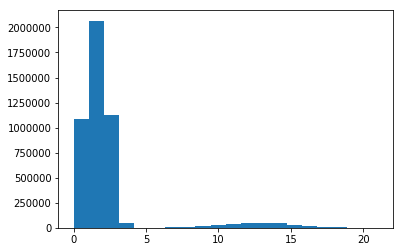

In [25]:
plt.hist(df_train_dist['num_bond_C_0_x'], bins=20)
plt.show()

In [40]:
df_train_dist['num_bond_C_0_x'].value_counts()

2.0    2067097
3.0    1127063
1.0    1087409
4.0     376571
0.0          7
Name: num_bond_C_0_x, dtype: int64

In [39]:
for i in range(5):
    temp = df_train_dist['num_bond_C_{}_x'.format(i)]
    temp = temp.where(temp < 5, 4)
    df_train_dist['num_bond_C_{}_x'.format(i)] = temp

In [41]:
df_train_dist['type'].value_counts()

3JHC    1510379
2JHC    1140674
1JHC     709416
3JHH     590611
2JHH     378036
3JHN     166415
2JHN     119253
1JHN      43363
Name: type, dtype: int64